# Predict CO2 Emissions In Rwanda

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Analysis of KDE plots
Notice how because the distribution in values is similar, the general shape of each graph is similar. However, because the sample size is different, each graph is either consistently above or below another, meaning the area under each graph is not 1.

Now, notice how when each dataset has the same number of data points, but the distribution is a bit off, the approximate height of each graph is similar, but the shape is very different.

The key insight is that, in terms of distribution, the over all shape of the graph matters a lot more than the "height" of the graph.

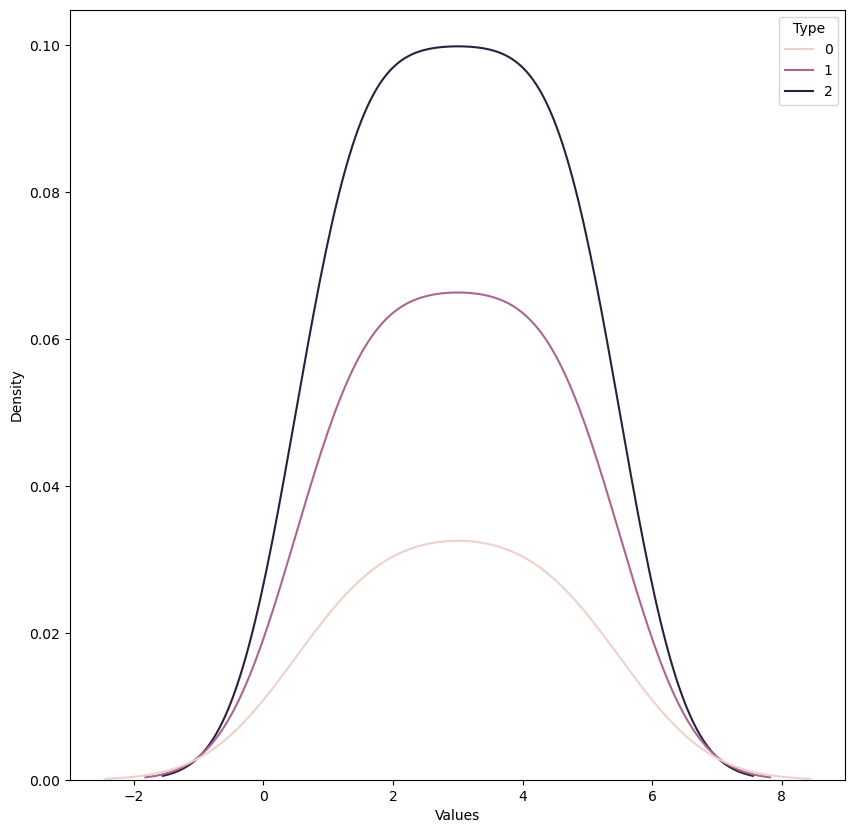

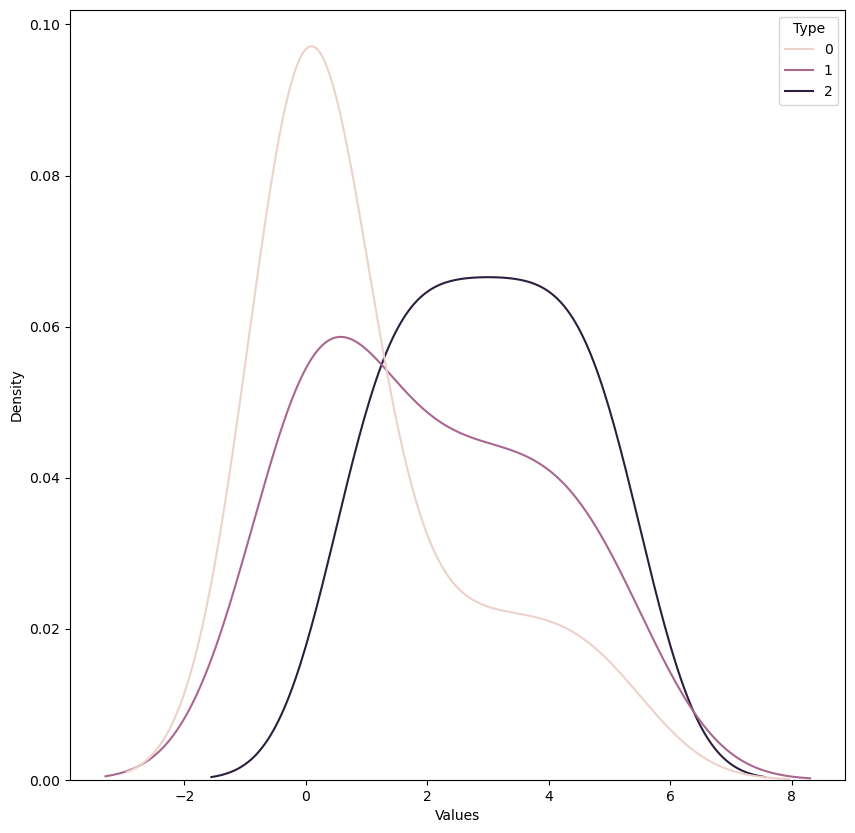

In [2]:
def plot_kde(arrs):
    for i in range(len(arrs)):
        arrs[i] = [arrs[i], [i for j in range(len(arrs[i]))]]
    
    Values = []
    Type = []
    for i in range(len(arrs)):
        Values+=arrs[i][0]
        Type+=arrs[i][1]

    data = pd.DataFrame(list(zip(Values, Type)), columns=['Values', 'Type'])

    plt.figure(figsize=(10, 10))
    sns.kdeplot(data, x = 'Values', hue = 'Type')
    plt.show()
    
arrs = [
    [1, 2, 3, 4, 5],
    [1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
]

plot_kde(arrs)

arrs = [
    [1, 2, 3, 4, 5],
    [1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
]

# Add 0s
for i in range(len(arrs)-1):
    while len(arrs[i])<len(arrs[-1]):
        arrs[i].append(0)
plot_kde(arrs)

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")

display(train_data.head())

train_X = train_data.drop(['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1)
train_y = train_data['emission']

no_id_test_data = test_data.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1)

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
1  ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
2  ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
3  ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
4  ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                       0.255668                           -98.593887  ...   
1                       0.130988                            16.592861  ...   
2                       0.110018                            72.795837  ...   
3                            NaN                                  NaN  ...   
4                       0.121164                             4.121269  ...   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0             3664.436218               61085.809570              2615.120483   
1             3651.190311               66969.478735              3174.572424   
2             4216.986492               60068.894448              3516.282669   
3             5228.507736               51064.547339              4180.973322   
4             3980.598120               63751.125781              3355.710107   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                  15.568533              0.272292   
1                   8.690601              0.256830   
2                  21.103410              0.251101   
3                  15.386899              0.262043   
4                   8.114694              0.235847   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                  -12.628986                  35.632416   
1                   30.359375                  39.557633   
2                   15.377883                  30.401823   
3                  -11.293399                  24.380357   
4                   38.532263                  37.392979   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                -138.786423                 30.752140  3.750994  
1                -145.183930                 27.251779  4.025176  
2                -142.519545                 26.193296  4.231381  
3                -132.665828                 28.829155  4.305286  
4                -141.509805                 22.204612  4.347317  

[5 rows x 76 columns]

In [4]:
correlation = train_data.corr()

corr_emission = []

display(correlation)

for i in correlation.columns:
    corr_emission.append((correlation[i]['emission'], i))
    
corr_emission.sort()
corr_emission.reverse()

display(corr_emission[0:10])

/tmp/ipykernel_20/1773925342.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_data.corr()


latitude     longitude  \
latitude                                  1.000000e+00  2.395107e-01   
longitude                                 2.395107e-01  1.000000e+00   
year                                     -7.655199e-12 -2.426783e-12   
week_no                                   9.627213e-16  1.351900e-16   
SulphurDioxide_SO2_column_number_density  3.506502e-03 -1.296603e-01   
...                                                ...           ...   
Cloud_sensor_azimuth_angle               -1.040397e-02 -1.670147e-02   
Cloud_sensor_zenith_angle                -2.123935e-02 -3.498283e-02   
Cloud_solar_azimuth_angle                -2.873817e-02 -5.246878e-03   
Cloud_solar_zenith_angle                 -2.044945e-02  8.237818e-03   
emission                                  1.785056e-02  1.027465e-01   

                                                  year       week_no  \
latitude                                 -7.655199e-12  9.627213e-16   
longitude                                -2.426783e-12  1.351900e-16   
year                                      1.000000e+00  4.205332e-15   
week_no                                   4.205332e-15  1.000000e+00   
SulphurDioxide_SO2_column_number_density  5.307611e-03  3.520293e-03   
...                                                ...           ...   
Cloud_sensor_azimuth_angle                2.229069e-03 -7.341750e-03   
Cloud_sensor_zenith_angle                 2.096993e-02  6.281243e-02   
Cloud_solar_azimuth_angle                 3.942886e-03 -7.615557e-02   
Cloud_solar_zenith_angle                  8.929194e-04  3.948029e-01   
emission                                 -1.324371e-02  7.085970e-03   

                                          SulphurDioxide_SO2_column_number_density  \
latitude                                                                  0.003507   
longitude                                                                -0.129660   
year                                                                      0.005308   
week_no                                                                   0.003520   
SulphurDioxide_SO2_column_number_density                                  1.000000   
...                                                                            ...   
Cloud_sensor_azimuth_angle                                                0.018298   
Cloud_sensor_zenith_angle                                                 0.023467   
Cloud_solar_azimuth_angle                                                 0.040240   
Cloud_solar_zenith_angle                                                  0.050530   
emission                                                                 -0.019126   

                                          SulphurDioxide_SO2_column_number_density_amf  \
latitude                                                                      0.045013   
longitude                                                                     0.086797   
year                                                                         -0.127962   
week_no                                                                       0.064327   
SulphurDioxide_SO2_column_number_density                                     -0.068732   
...                                                                                ...   
Cloud_sensor_azimuth_angle                                                   -0.051254   
Cloud_sensor_zenith_angle                                                    -0.024777   
Cloud_solar_azimuth_angle                                                    -0.147166   
Cloud_solar_zenith_angle                                                      0.040611   
emission                                                                      0.000347   

                                          SulphurDioxide_SO2_slant_column_number_density  \
latitude                                                                        0.007386   
longitude         

[(1.0, 'emission'),
 (0.1027464904365297, 'longitude'),
 (0.06900838216391907, 'UvAerosolLayerHeight_aerosol_height'),
 (0.04658675496974502, 'Cloud_surface_albedo'),
 (0.04026290944701478,
  'Formaldehyde_tropospheric_HCHO_column_number_density_amf'),
 (0.040155530762151385, 'UvAerosolLayerHeight_aerosol_optical_depth'),
 (0.035142140559449704, 'UvAerosolLayerHeight_sensor_azimuth_angle'),
 (0.027540002156437888, 'NitrogenDioxide_sensor_altitude'),
 (0.02245642739489716, 'NitrogenDioxide_cloud_fraction'),
 (0.020905477365425255, 'NitrogenDioxide_absorbing_aerosol_index')]

/tmp/ipykernel_20/3340754796.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = display_data.loc[display_data.Source == 'Test'], x = col_name, ax = plot, linewidth = 2)


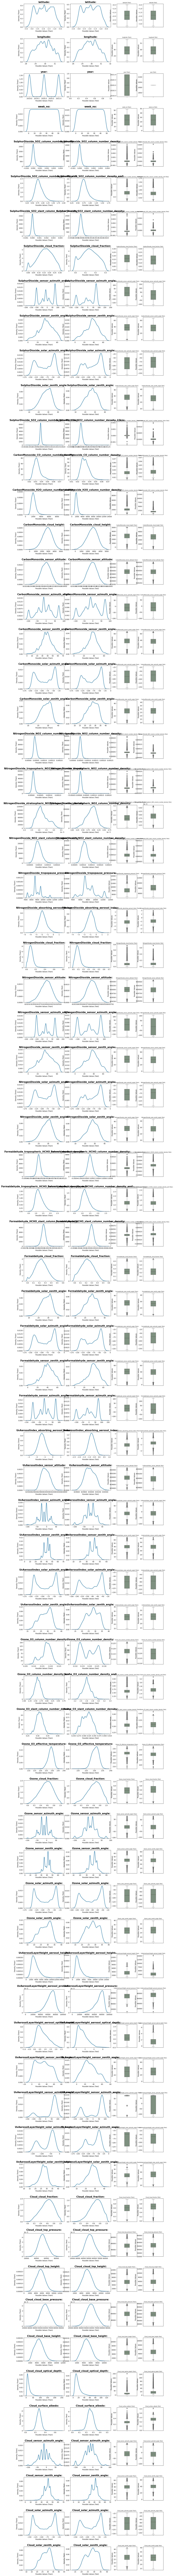

In [5]:
display_data = pd.concat(
    [train_data.drop(['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1).assign(Source = 'Train'), 
     test_data.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1).assign(Source = 'Test')], ignore_index = True)

cols = display_data.columns.tolist()[0:-1]

fig, axes = plt.subplots(
    len(cols), 
    4, 
    figsize = (16, len(cols)*4), 
    gridspec_kw = {'wspace':0.2, 'hspace':0.5, 'width_ratios':[0.4, 0.4, 0.2, 0.2]})

for i, col_name in enumerate(cols):
    
    # KDE plot (train)
    plot = axes[i][0]
    sns.kdeplot(data = display_data.loc[display_data.Source == 'Train'], x = col_name, ax = plot, linewidth = 2)
    plot.set_title(f"{col_name}:", fontsize = 15, fontweight = 'bold')
    plot.set(xlabel = "Possible Values (Train)", ylabel = "Density (Train)")
    
    # KDE plot (test)
    plot = axes[i][1]
    sns.kdeplot(data = display_data.loc[display_data.Source == 'Test'], x = col_name, ax = plot, linewidth = 2)
    plot.set_title(f"{col_name}:", fontsize = 15, fontweight = 'bold')
    plot.set(xlabel = "Possible Values (Test)", ylabel = "Density (Test)")
    
    # Box plot (train)
    plot = axes[i][2]
    sns.boxplot(data = display_data.loc[display_data.Source == 'Train', [col_name]], y = col_name, color = '#7E9181', width = 0.25, saturation = 1, linewidth = 1, ax = plot)
    plot.set_title(f"{col_name} (Train):", fontsize = 7)
    plot.set(xlabel = "", ylabel = "Possible Values")
    
    # Box plot (test)
    plot = axes[i][3]
    sns.boxplot(data = display_data.loc[display_data.Source == 'Test', [col_name]], y = col_name, color = '#7E9181', width = 0.25, saturation = 1, linewidth = 1, ax = plot)
    plot.set_title(f"{col_name} (Test):", fontsize = 7)
    plot.set(xlabel = "", ylabel = "Possible Values")
    
    
plt.show()

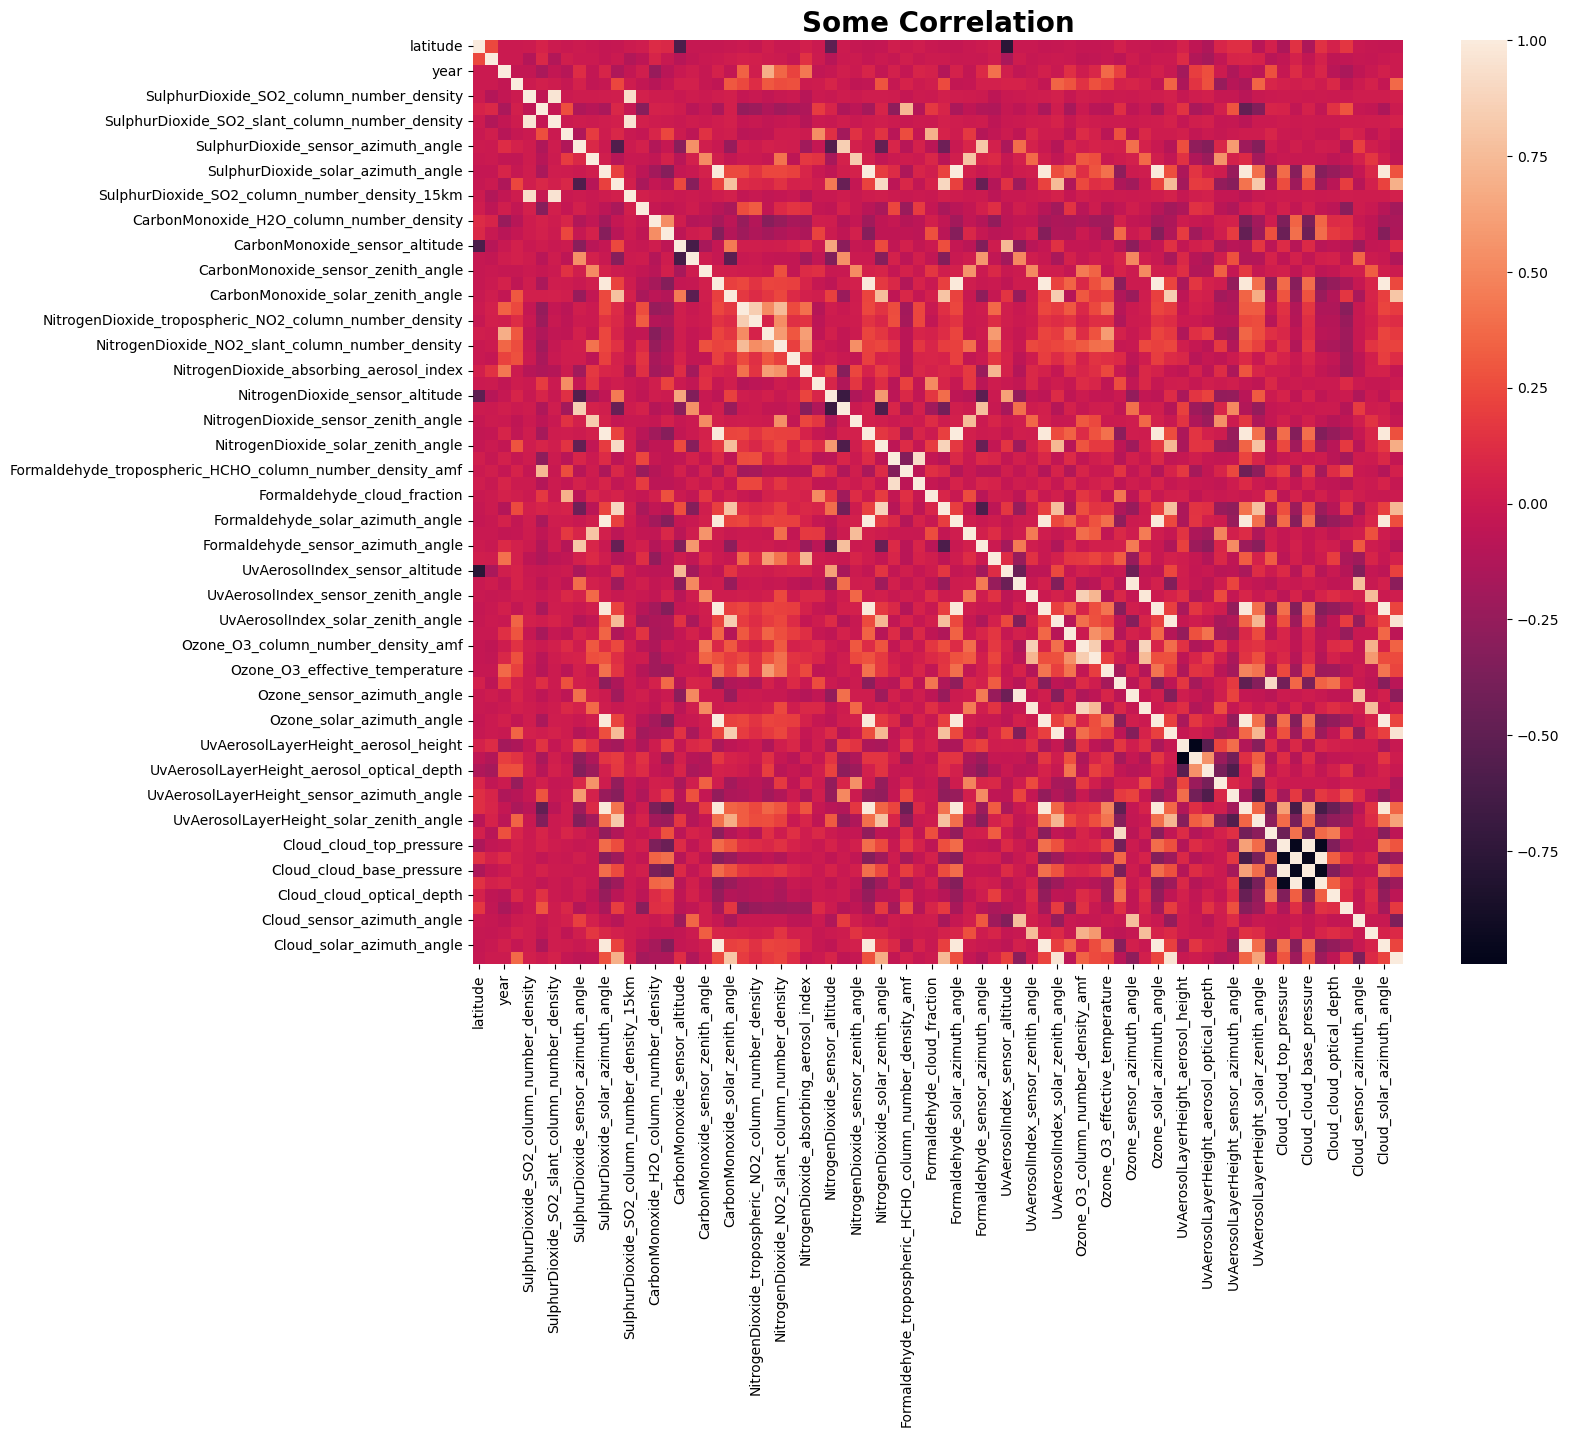

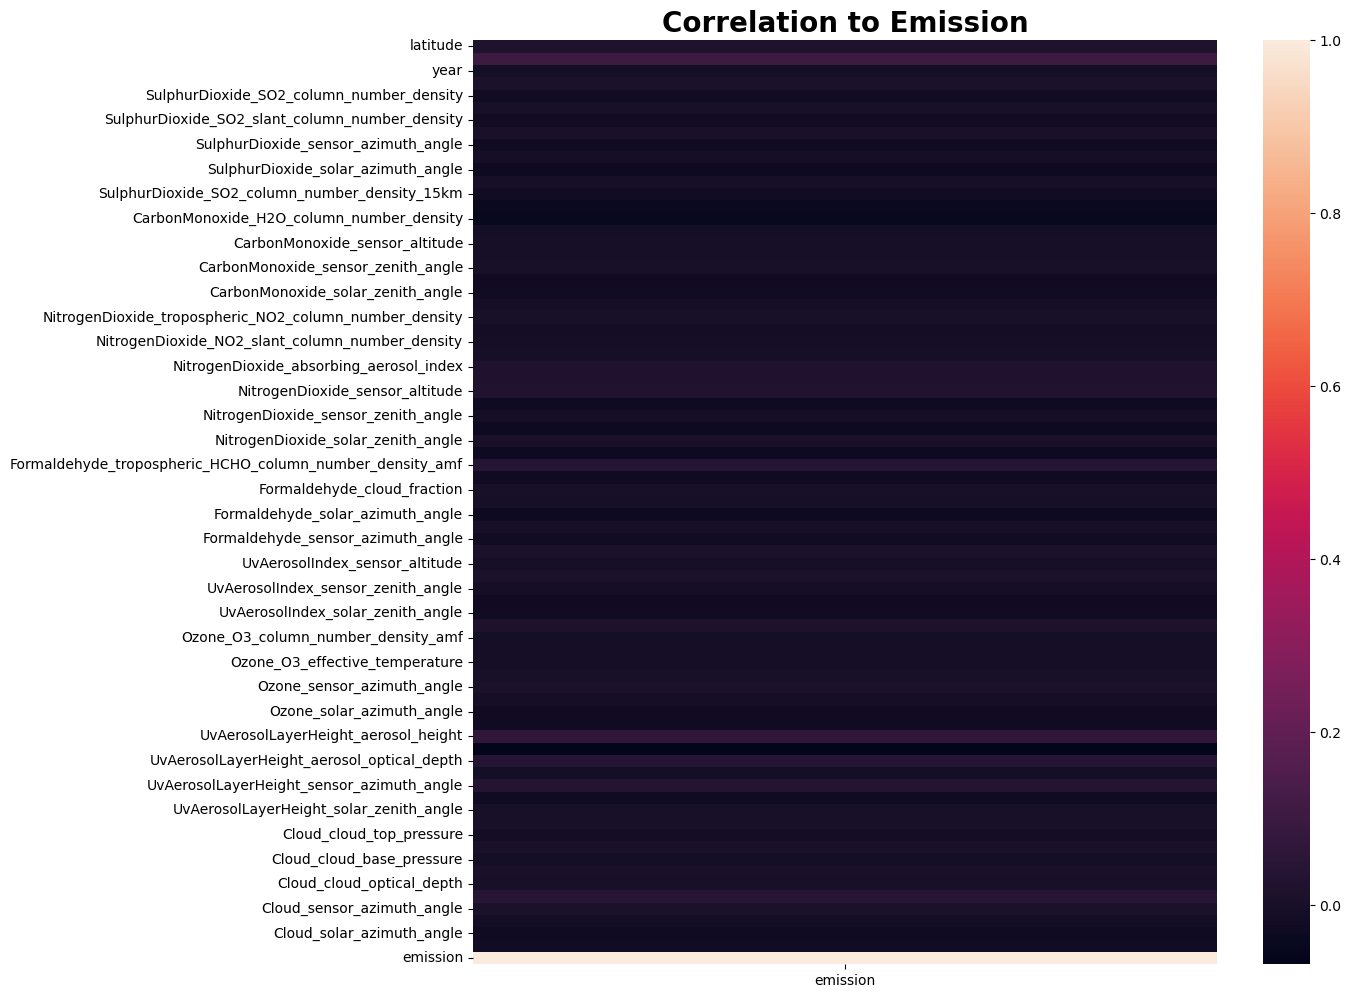

In [6]:
plt.figure(figsize=(15, 12))
sns.heatmap(display_data.corr(numeric_only=True))
plt.title("Some Correlation", fontsize = 20, fontweight = "bold")
plt.show()

corr_emission = pd.DataFrame(train_data.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1).corr().loc['emission'], columns=['emission'])
plt.figure(figsize=(12, 12))
sns.heatmap(corr_emission)
plt.title('Correlation to Emission', fontsize = 20, fontweight = 'bold')
plt.show()

Column_Name Num_Missing_Values
5         SulphurDioxide_SO2_column_number_density              14609
6     SulphurDioxide_SO2_column_number_density_amf              14609
7   SulphurDioxide_SO2_slant_column_number_density              14609
8                    SulphurDioxide_cloud_fraction              14609
9              SulphurDioxide_sensor_azimuth_angle              14609
..                                             ...                ...
70                            Cloud_surface_albedo                484
71                      Cloud_sensor_azimuth_angle                484
72                       Cloud_sensor_zenith_angle                484
73                       Cloud_solar_azimuth_angle                484
74                        Cloud_solar_zenith_angle                484

[70 rows x 2 columns]

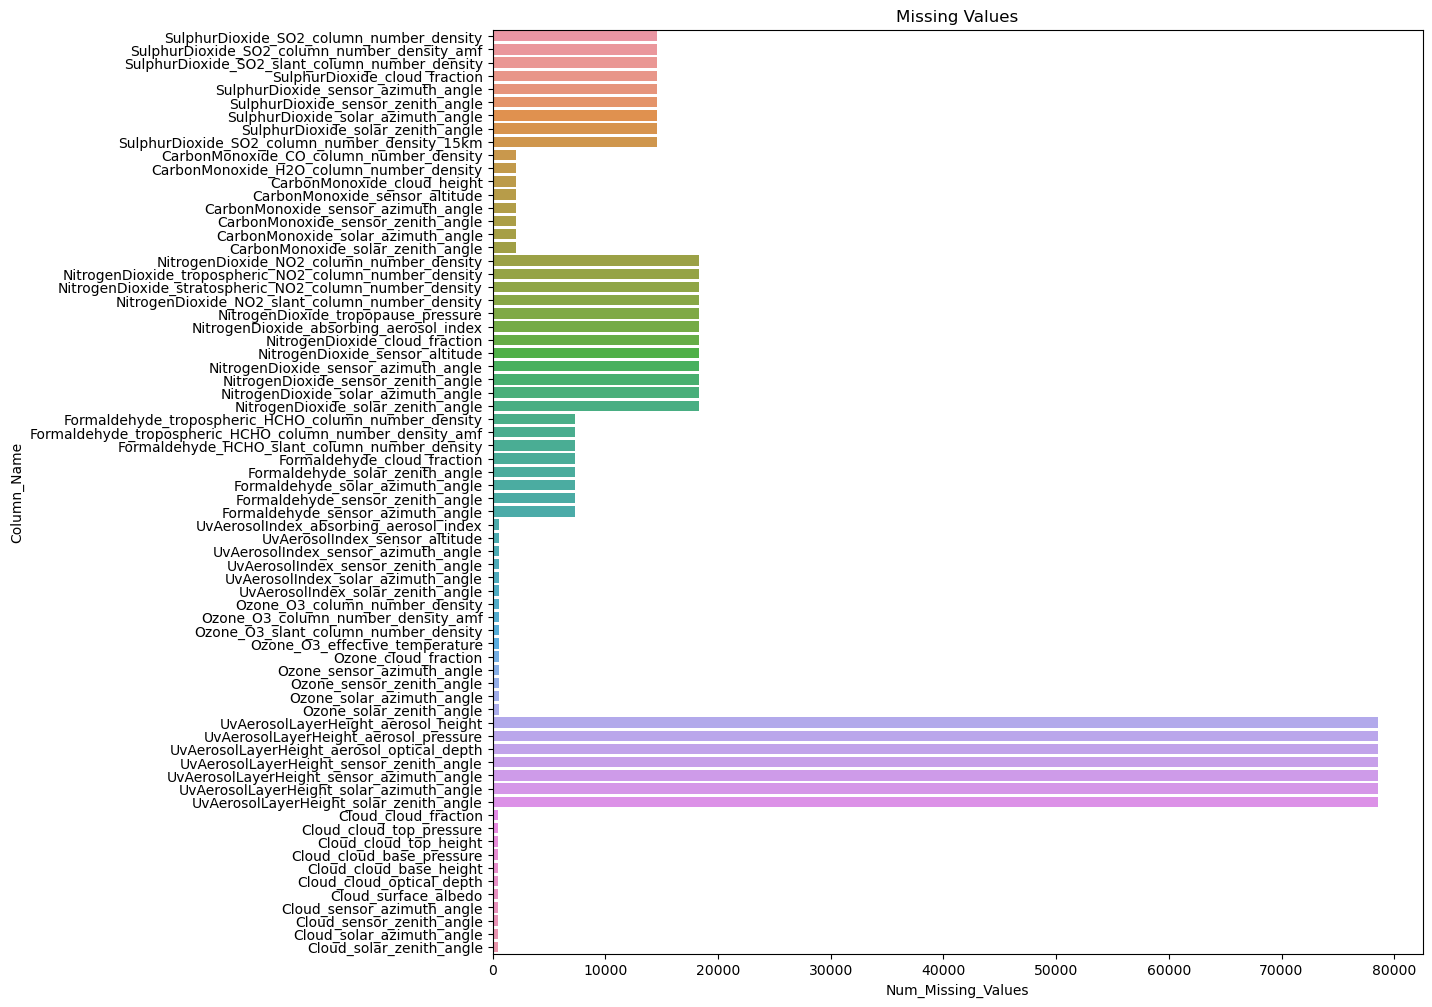

In [7]:
missing_values = [[], []]

for i in train_data.columns:
    missing_values[0].append(i)
    missing_values[1].append(train_data[i].isna().sum())
    
missing_values = pd.DataFrame(missing_values).T #.transpose
missing_values.columns = ['Column_Name', 'Num_Missing_Values']

missing_values = missing_values.loc[missing_values.Num_Missing_Values > 0, :]

display(missing_values)

plt.figure(figsize=(12, 12))
plt.title("Missing Values")
sns.barplot(missing_values, y = 'Column_Name', x = 'Num_Missing_Values', orient='h')
plt.show()

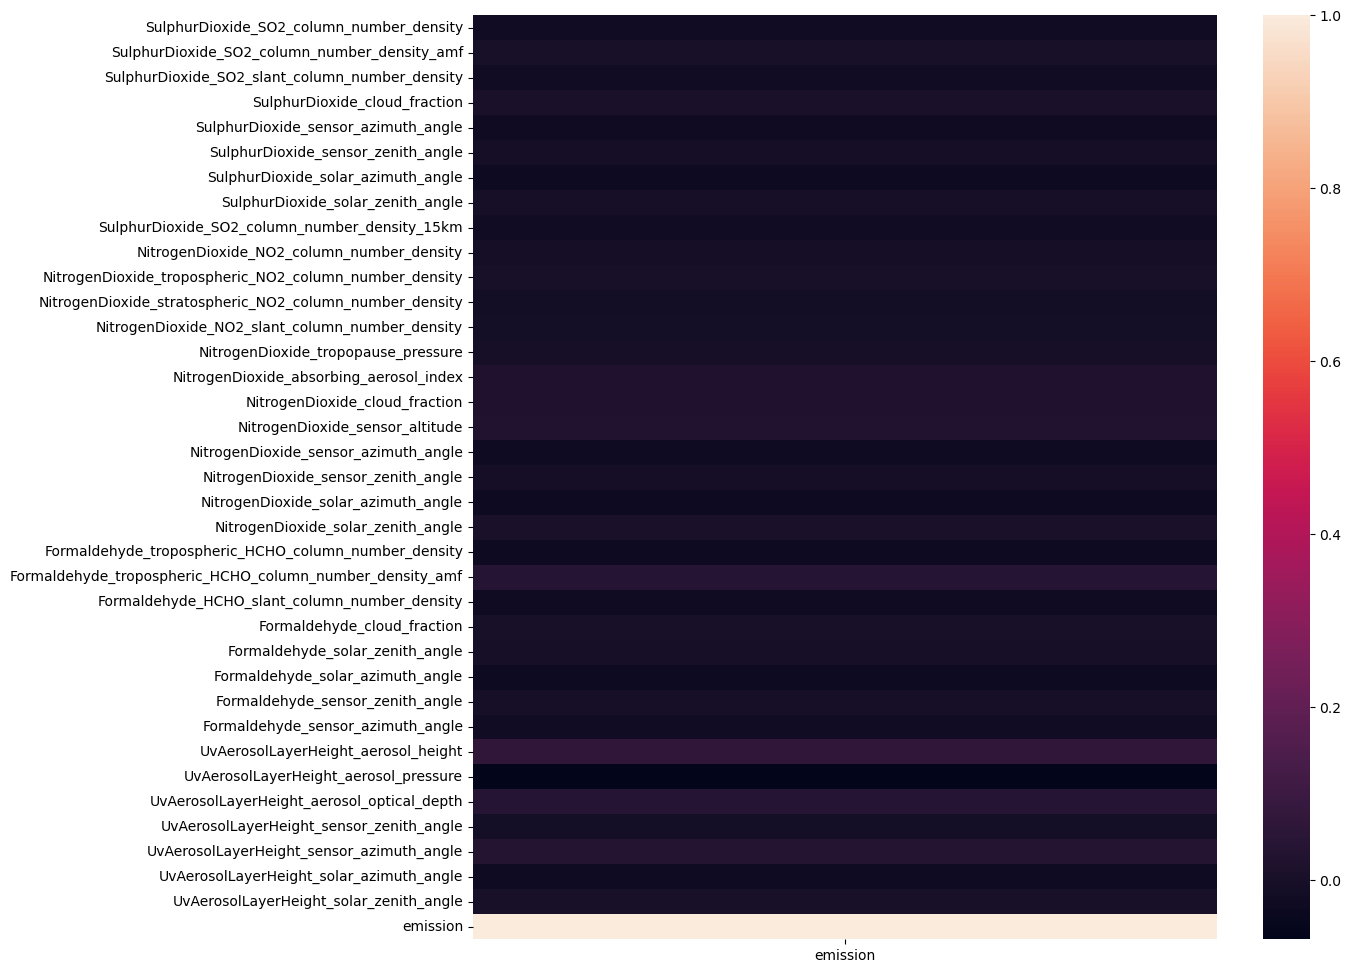

In [8]:
lot_of_nan = []

for i in range(missing_values.shape[0]):
    if missing_values['Num_Missing_Values'].iloc[i] > 5000:
        lot_of_nan.append(missing_values['Column_Name'].iloc[i])
        
plt.figure(figsize = (12, 12))
sns.heatmap(train_data[lot_of_nan+['emission']].corr().loc[..., ['emission']])
plt.show()

# Feature Engineering
Only use non-satellite gathered columns because Ambrosm said so!

In [9]:
non_satellite_features = ['latitude', 'longitude', 'year', 'week_no']

def feature_engineering(data):
    
    if('emission' in list(data.columns)):
        data[non_satellite_features+['emission']]
        data.dropna()
        
        return data[non_satellite_features], data['emission']
    
    ret = data[non_satellite_features]
    return ret

train_X, train_y = feature_engineering(train_data)

display(train_X.isna().sum())
display(train_y.isna().sum())
display(len(train_X))
display(len(train_y))

no_id_test_data = feature_engineering(no_id_test_data)

display(no_id_test_data.isna().sum())

display(train_X)
display(train_y)
display(train_X.shape)
display(train_y.shape)
display(train_X.dtypes)
display(train_y.dtype)

latitude     0
longitude    0
year         0
week_no      0
dtype: int64

0

79023

79023

latitude     0
longitude    0
year         0
week_no      0
dtype: int64

latitude  longitude  year  week_no
0        -0.510     29.290  2019        0
1        -0.510     29.290  2019        1
2        -0.510     29.290  2019        2
3        -0.510     29.290  2019        3
4        -0.510     29.290  2019        4
...         ...        ...   ...      ...
79018    -3.299     30.301  2021       48
79019    -3.299     30.301  2021       49
79020    -3.299     30.301  2021       50
79021    -3.299     30.301  2021       51
79022    -3.299     30.301  2021       52

[79023 rows x 4 columns]

0         3.750994
1         4.025176
2         4.231381
3         4.305286
4         4.347317
           ...    
79018    29.404171
79019    29.186497
79020    29.131205
79021    28.125792
79022    27.239302
Name: emission, Length: 79023, dtype: float64

(79023, 4)

(79023,)

latitude     float64
longitude    float64
year           int64
week_no        int64
dtype: object

dtype('float64')

# Hyperparameter Tuning

In [10]:
def optuna_study(x, y):
    
    def objective(trial):
        
        n_estimators = trial.suggest_int('n_estimators', 10, 300)
        learning_rate = trial.suggest_int('learning_rate', 0.01, 1.0)
        max_depth = trial.suggest_int('max_depth', 1, 30)
        
        rf = XGBRegressor(n_estimators = n_estimators,
                         learning_rate = learning_rate,
                         max_depth = max_depth)
        
        # Be careful that scoring metric is suitable for task (e.g. regression vs. 
        # classification)
        # I.e. I used "roc_auc" scoring which raised error because it's for 
        # classification, and this is regression.
        score = cross_val_score(rf, x, y, n_jobs = 4, cv = 4, scoring = 'neg_root_mean_squared_error')
        return score.mean()
        
    study = optuna.create_study(direction='maximize')

    study.optimize(objective, n_trials = 20)
    
    return study.best_params

best_params = optuna_study(train_X, train_y)

[I 2023-08-21 17:00:56,579] A new study created in memory with name: no-name-90eabe08-246a-4524-bdc6-2d678d586e00
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this ve

# Inference & Submission

In [11]:
final_model = XGBRegressor(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    learning_rate = best_params['learning_rate'],
    n_jobs = 4
)

final_model.fit(train_X, train_y)
preds = final_model.predict(no_id_test_data)

submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_data.ID_LAT_LON_YEAR_WEEK, 'emission': preds})

submission.to_csv(f'submission.csv', index=False)

display("Hooray!")

'Hooray!'